In [1]:
import os
import glob
import pyart
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy import stats

#load up profiles
path = '/g/data1a/kl02/jss548/hail-research/profile_data/*.nc'
profile_file_list = sorted(glob.glob(path))

first_profile = True

for profile_file in profile_file_list:
    with netCDF4.Dataset(profile_file, "r") as ncid:
        refl_data = ncid['refl_prof'][:]
        temp_data = ncid['temp_prof'][:]
        zdr_data  = ncid['zdr_prof'][:]
        rhv_data  = ncid['rhv_prof'][:]
        hsda_data = ncid['hsda_prof'][:]
        hca_data  = ncid['hca_prof'][:]
        hdr_data  = ncid['hdr_prof'][:]
        mesh_data = ncid['mesh_prof'][:]
        alt_data  = ncid['profile_alt'][:]
        
    if first_profile:
        refl_prof     = refl_data
        temp_prof     = temp_data
        zdr_prof      = zdr_data
        rhv_prof      = rhv_data
        hsda_prof     = hsda_data
        hca_prof      = hca_data
        hdr_prof      = hdr_data
        mesh_val      = mesh_data
        alt_vec       = alt_data
        first_profile = False
    else:
        refl_prof = np.append(refl_prof, refl_data, axis = 1)
        temp_prof = np.append(temp_prof, temp_data, axis = 1)
        zdr_prof  = np.append(zdr_prof,  zdr_data, axis = 1)
        rhv_prof  = np.append(rhv_prof,  rhv_data, axis = 1)
        hsda_prof = np.append(hsda_prof, hsda_data, axis = 1)
        hca_prof  = np.append(hca_prof,  hca_data, axis = 1)
        hdr_prof  = np.append(hdr_prof,  hdr_data, axis = 1)
        mesh_val  = np.append(mesh_val, mesh_data)
        
print('data loaded')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: i

data loaded


In [2]:
prof_sz  = np.shape(refl_prof)
alt_prof = np.tile(alt_vec, (prof_sz[1], 1))
alt_prof = np.swapaxes(alt_prof,1,0)

#convert HDR to size
#hdr_prof_mm = (0.0284*(hdr_prof**2))-(0.366*hdr_prof)+11.69 

#mask HCA for hail
# hca_prof_hail = hca_prof==9

#bin hdr
hdr_bins = np.zeros_like(hdr_prof)
hdr_bins[hdr_prof > 0]   = 1 
hdr_bins[hdr_prof > 25]  = 2
hdr_bins[hdr_prof > 50]  = 3

#replace nan in hsda with 0
hsda_prof[np.isnan(hsda_prof)] = 0

#remove entries below freezing level
tmask           = temp_prof > 5
hsda_prof_maskt = hsda_prof[tmask]
hca_prof_maskt  = hca_prof[tmask]
hdr_bins_maskt  = hdr_bins[tmask]
hdr_prof_maskt  = hdr_prof[tmask]
refl_prof_maskt = refl_prof[tmask]
zdr_prof_maskt  = zdr_prof[tmask]
alt_prof_maskt  = alt_prof[tmask]

#remove entries which have both nonhail HCA and hdr 0
mask           = np.invert(np.logical_and(np.invert(hca_prof_maskt==9), hdr_bins_maskt==0))
hsda_prof_mask = hsda_prof_maskt[mask]
hca_prof_mask  = hca_prof_maskt[mask]
hdr_bins_mask  = hdr_bins_maskt[mask]
hdr_prof_mask  = hdr_prof_maskt[mask]
refl_prof_mask = refl_prof_maskt[mask]
zdr_prof_mask  = zdr_prof_maskt[mask]
alt_prof_mask  = alt_prof_maskt[mask]

#check for matches
total       = np.sum(mask)

# total_bins = len(hsda_prof_mask.flatten())
# print(round(np.sum(np.isnan(hsda_prof_mask))/total_bins*100))
# print(round(np.sum(hsda_prof_mask==0)/total_bins*100))
# print(round(np.sum(hsda_prof_mask==1)/total_bins*100))
# print(round(np.sum(hsda_prof_mask==2)/total_bins*100))
# print(round(np.sum(hsda_prof_mask==3)/total_bins*100))
# print('')
# total_bins = len(hdr_bins_mask.flatten())
# print(round(np.sum(hdr_bins_mask==0)/total_bins*100))
# print(round(np.sum(hdr_bins_mask==1)/total_bins*100))
# print(round(np.sum(hdr_bins_mask==2)/total_bins*100))
# print(round(np.sum(hdr_bins_mask==3)/total_bins*100))

#check for detection
match_flag        = np.logical_and(hdr_bins_mask>0, hca_prof_mask==9)
nohdr_hail_flag   = np.logical_and(hdr_bins_mask==0, hca_prof_mask==9)
hdr_nohail_flag   = np.logical_and(hdr_bins_mask>0, hca_prof_mask!=9)

match_total        = np.sum(match_flag)
nohdr_hail_total   = np.sum(nohdr_hail_flag)
hdr_nohail_total   = np.sum(hdr_nohail_flag)


matches_f  = np.sum(np.invert(match_flag))
matches_f1 = np.sum(hsda_prof_mask[np.invert(match_flag)] == 1)
matches_f2 = np.sum(hsda_prof_mask[np.invert(match_flag)] == 2)
matches_f3 = np.sum(hsda_prof_mask[np.invert(match_flag)] == 3)
matches_f0 = np.sum(hsda_prof_mask[np.invert(match_flag)] == 0)

print('HSDA size 0: no hail')
print('HSDA size 1: 0-25 mm')
print('HSDA size 2: 25-50 mm')
print('HSDA size 3: 50+ mm')
print('')

print( 'total detection matches ', round(np.sum(match_total)/total*100), '% of ', total)
print('')
print( 'valid hdr but no hail ', round(np.sum(nohdr_hail_total)/total*100), '% of ', total)
print( 'valid hail but no hdr ', round(np.sum(hdr_nohail_total)/total*100), '% of ', total)

print('')
print( 'hdr misses for hsda size 0', round(np.sum(matches_f0)/matches_f*100), '% of ', matches_f)
print( 'hdr misses for hsda size 1', round(np.sum(matches_f1)/matches_f*100), '% of ', matches_f)
print( 'hdr misses for hsda size 2', round(np.sum(matches_f2)/matches_f*100), '% of ', matches_f)
print( 'hdr misses for hsda size 3', round(np.sum(matches_f3)/matches_f*100), '% of ', matches_f)
print('')

#check for size matching
matches_sz  = np.sum( hdr_bins_mask == hsda_prof_mask)
matches_sz1 = np.sum( np.logical_and(hsda_prof_mask==1, hdr_bins_mask==1 ))
matches_sz2 = np.sum( np.logical_and(hsda_prof_mask==2, hdr_bins_mask==2 ))
matches_sz3 = np.sum( np.logical_and(hsda_prof_mask==3, hdr_bins_mask==3 ))
total1      = np.sum( hsda_prof_mask==1 )
total2      = np.sum( hsda_prof_mask==2 )
total3      = np.sum( hsda_prof_mask==3 )
total0      = np.sum( hsda_prof_mask==0 )

print( 'percentage of HDR matches:', round(matches_sz/total*100),   '% of', total,  'pixels with HSDA values' )
print("")
print( 'percentage of HDR matches:', round(matches_sz1/total1*100), '% of', total1, 'pixels where HSDA = 1' )
print( 'percentage of HDR matches:', round(matches_sz2/total2*100), '% of', total2, 'pixels where HSDA = 2'  )
print( 'percentage of HDR matches:', round(matches_sz3/total3*100), '% of', total3, 'pixels where HSDA = 3'  )
print( total0, 'HSDA pixels with 0 value not included. This is',round(total0/total*100),'% of the total')

/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


HSDA size 0: no hail
HSDA size 1: 0-25 mm
HSDA size 2: 25-50 mm
HSDA size 3: 50+ mm

total detection matches  37.0 % of  270890

valid hdr but no hail  37.0 % of  270890
valid hail but no hdr  26.0 % of  270890

hdr misses for hsda size 0 44.0 % of  170155
hdr misses for hsda size 1 55.0 % of  170155
hdr misses for hsda size 2 0.0 % of  170155
hdr misses for hsda size 3 0.0 % of  170155

percentage of HDR matches: 33.0 % of 270890 pixels with HSDA values

percentage of HDR matches: 47.0 % of 180443 pixels where HSDA = 1
percentage of HDR matches: 4.0 % of 2535 pixels where HSDA = 2
percentage of HDR matches: 0.0 % of 10823 pixels where HSDA = 3
77089 HSDA pixels with 0 value not included. This is 28.0 % of the total


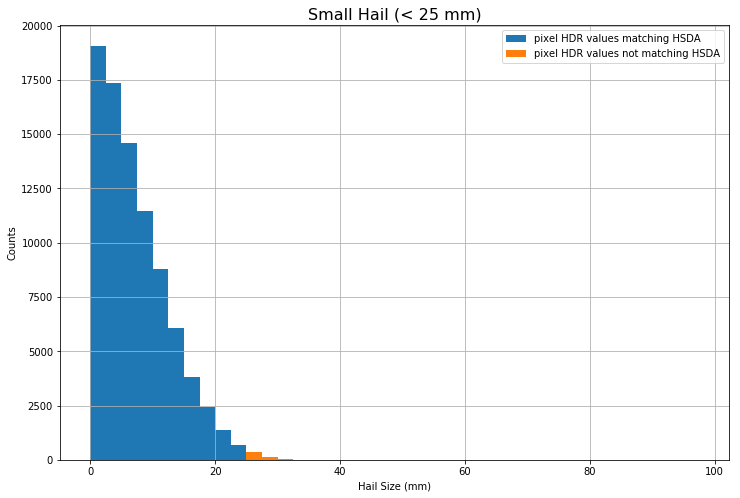

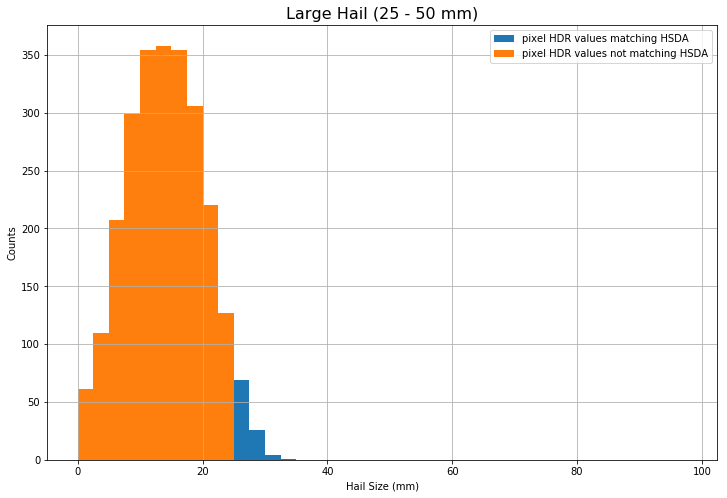

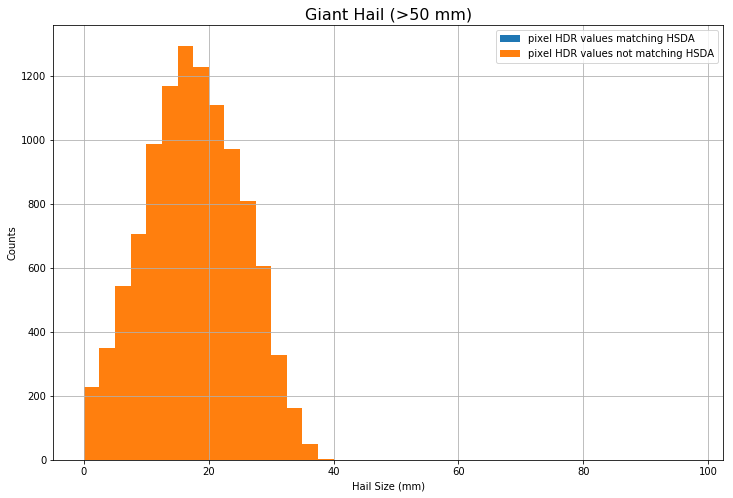

In [3]:
#plot mesh distribution for when size matches and when it fails to match

matches_sz1_tf = hdr_bins_mask[hsda_prof_mask==1] == 1
matches_sz2_tf = hdr_bins_mask[hsda_prof_mask==2] == 2
matches_sz3_tf = hdr_bins_mask[hsda_prof_mask==3] == 3


fig       = plt.figure(figsize=(12, 8), facecolor='w')
hdr_val_1 = hdr_prof_mask[hsda_prof_mask==1]
plt.hist(hdr_val_1[matches_sz1_tf], bins=np.arange(0,27.5,2.5), histtype='stepfilled')
plt.hist(hdr_val_1[np.invert(matches_sz1_tf)],  bins=np.arange(25,100,2.5), histtype='stepfilled')
plt.legend(['pixel HDR values matching HSDA', 'pixel HDR values not matching HSDA'])
plt.title('Small Hail (< 25 mm)', fontsize=16)
plt.xlabel('Hail Size (mm)')
plt.ylabel('Counts')
plt.grid()

fig       = plt.figure(figsize=(12, 8), facecolor='w')
hdr_val_2 = hdr_prof_mask[hsda_prof_mask==2]
plt.hist(hdr_val_2[matches_sz2_tf], bins=np.arange(25,52.5,2.5), histtype='stepfilled')
plt.hist(hdr_val_2[np.invert(matches_sz2_tf)],  bins=np.arange(50,100,2.5), histtype='stepfilled')
plt.hist(hdr_val_2[np.invert(matches_sz2_tf)],  bins=np.arange(0,27.5,2.5), histtype='stepfilled', color='#ff7f0e')
plt.legend(['pixel HDR values matching HSDA', 'pixel HDR values not matching HSDA'])
plt.title('Large Hail (25 - 50 mm)', fontsize=16)
plt.xlabel('Hail Size (mm)')
plt.ylabel('Counts')
plt.grid()

fig       = plt.figure(figsize=(12, 8), facecolor='w')
hdr_val_3 = hdr_prof_mask[hsda_prof_mask==3]
plt.hist(hdr_val_3[matches_sz3_tf], bins=np.arange(50,100,2.5), histtype='stepfilled')
plt.hist(hdr_val_3[np.invert(matches_sz3_tf)],  bins=np.arange(0,100,2.5), histtype='stepfilled')
plt.legend(['pixel HDR values matching HSDA', 'pixel HDR values not matching HSDA'])
plt.title('Giant Hail (>50 mm)', fontsize=16)
plt.xlabel('Hail Size (mm)')
plt.ylabel('Counts')
plt.grid()

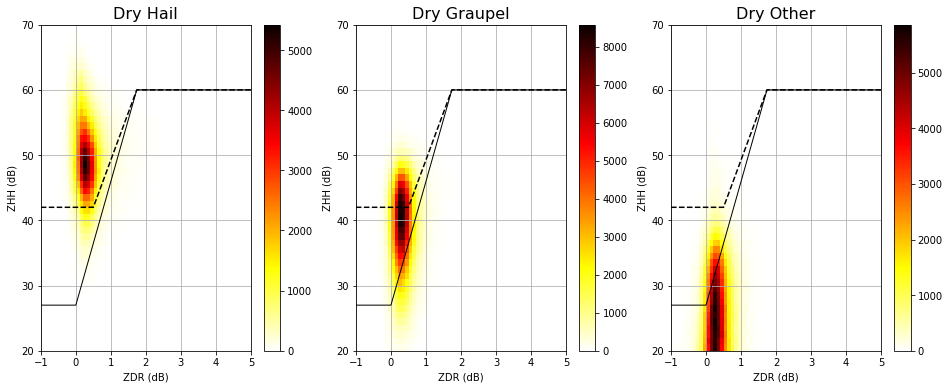

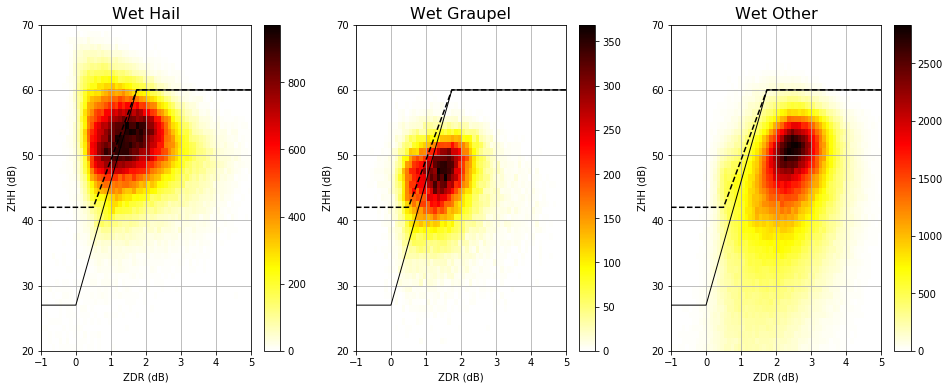

/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in less
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater
/g/data/en0/jss548/miniconda3/envs/radar/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


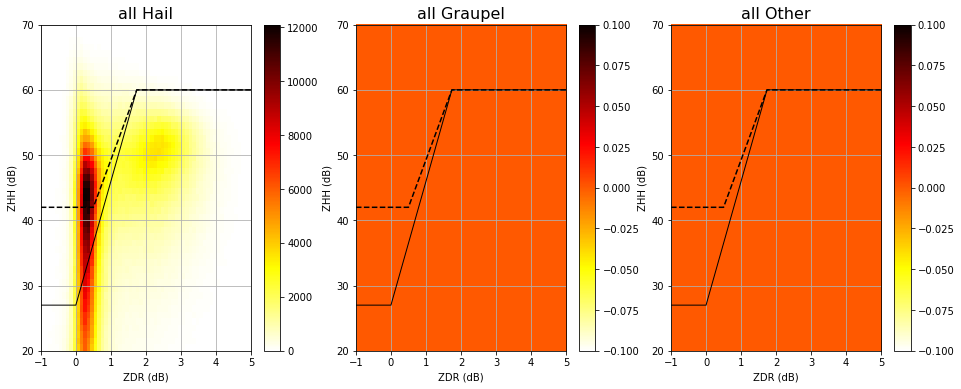

In [18]:
#load nans
nan_mask = ~np.logical_or(np.isnan(refl_prof), np.isnan(zdr_prof))
#clean fields
temp_prof_clean = temp_prof[nan_mask]
hca_prof_clean  = hca_prof[nan_mask]
refl_prof_clean = refl_prof[nan_mask]
zdr_prof_clean  = zdr_prof[nan_mask]

#mask out wet hail
wet_mask        = temp_prof_clean > 0
hca_prof_wet    = hca_prof_clean[wet_mask].flatten()
refl_prof_wet   = refl_prof_clean[wet_mask].flatten()
zdr_prof_wet    = zdr_prof_clean[wet_mask].flatten()
#mask out dry hail
dry_mask        = temp_prof_clean < -5
hca_prof_dry    = hca_prof_clean[dry_mask].flatten()
refl_prof_dry   = refl_prof_clean[dry_mask].flatten()
zdr_prof_dry    = zdr_prof_clean[dry_mask].flatten()
#hail mask
hail_mask_wet   = hca_prof_wet==9
hail_mask_dry   = hca_prof_dry==9
grap_mask_wet   = np.logical_or(hca_prof_wet==7, hca_prof_wet==8)
grap_mask_dry   = np.logical_or(hca_prof_dry==7, hca_prof_dry==8)

#HDR functions
hdr_old_x = [-1., 0., 1.74, 5.]
hdr_old_y = [27., 27., 60., 60.]
hdr_new_x = [-1., 0.5, 1.74, 5.]
hdr_new_y = [42.,42.,60.,60.]
plt_lim_x = [-1, 5]
plt_lim_y = [20, 70]

def plot_hist2d(zdr, zhh, mask1, mask2, title):
    
    def plot_function(x, y, mask, subid, title):
        plt.subplot(subid)
        hp = plt.hist2d(x[mask], y[mask], bins=[60,50],range=[[-1, 5], [20, 70]], cmap='hot_r')
        cbar = plt.colorbar(hp[3])
        plt.plot(hdr_old_x, hdr_old_y, 'k-', linewidth = 1.)
        plt.plot(hdr_new_x, hdr_new_y, 'k--', linewidth = 1.5)
        plt.xlim(plt_lim_x)
        plt.ylim(plt_lim_y)
        plt.grid(True)
        plt.xlabel('ZDR (dB)')
        plt.ylabel('ZHH (dB)')
        plt.title(title, fontsize=16)

    fig = plt.figure(figsize=(16, 6), facecolor='w')
    
    inverse_mask = np.invert(np.logical_or(mask1, mask2))
    plot_function(zdr, zhh, mask1, 131, title + ' Hail')
    plot_function(zdr, zhh, mask2, 132, title + ' Graupel')
    plot_function(zdr, zhh, inverse_mask, 133, title +  ' Other')
    plt.savefig(title + '_space_2dhistograms.png')    

    plt.show()


plot_hist2d(zdr_prof_dry, refl_prof_dry, hail_mask_dry, grap_mask_dry, 'Dry')
plot_hist2d(zdr_prof_wet, refl_prof_wet, hail_mask_wet, grap_mask_wet, 'Wet')

plot_hist2d(zdr_prof, refl_prof, refl_prof<999, refl_prof>999, 'all')

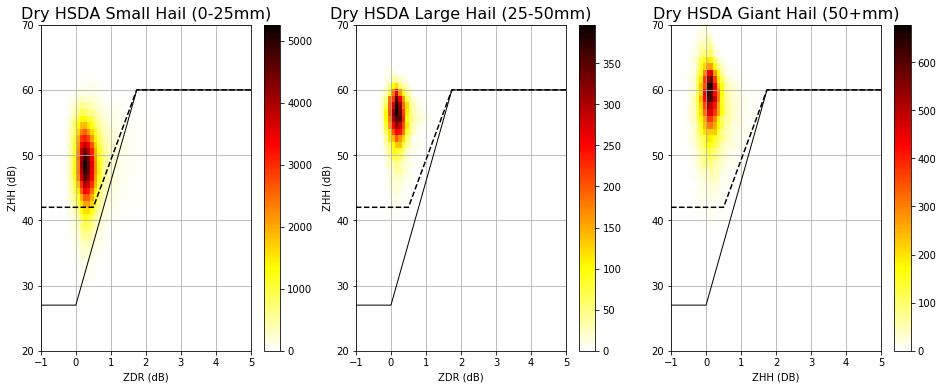

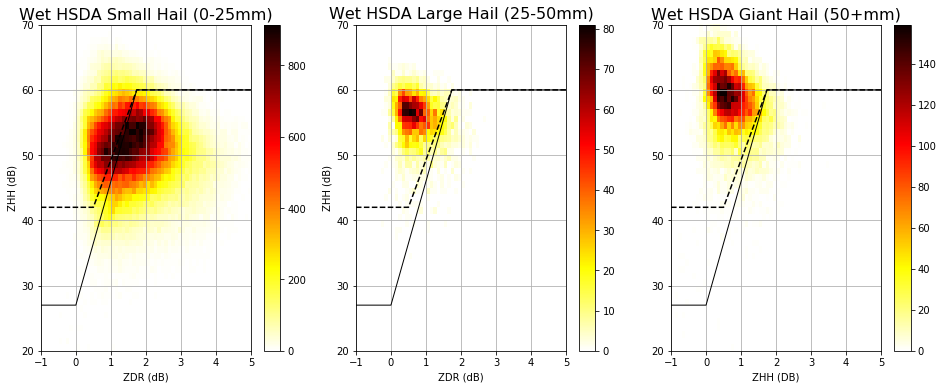

In [17]:
#load nans
nan_mask = ~np.logical_or(np.isnan(refl_prof), np.isnan(zdr_prof))
#clean fields
temp_prof_clean = temp_prof[nan_mask]
hsda_prof_clean = hsda_prof[nan_mask]
refl_prof_clean = refl_prof[nan_mask]
zdr_prof_clean  = zdr_prof[nan_mask]
rhv_prof_clean  = rhv_prof[nan_mask]

#mask out dry hail
dry_mask        = temp_prof_clean < -5
hsda_prof_dry   = hsda_prof_clean[dry_mask].flatten()
refl_prof_dry   = refl_prof_clean[dry_mask].flatten()
zdr_prof_dry    = zdr_prof_clean[dry_mask].flatten()
rhv_prof_dry    = rhv_prof_clean[dry_mask].flatten()

#mask out wet hail
wet_mask        = temp_prof_clean > 0
hsda_prof_wet   = hsda_prof_clean[wet_mask].flatten()
refl_prof_wet   = refl_prof_clean[wet_mask].flatten()
zdr_prof_wet    = zdr_prof_clean[wet_mask].flatten()
rhv_prof_wet    = rhv_prof_clean[wet_mask].flatten()



def plot_hist2d(zdr, zhh, hsda, title):
    
    fig = plt.figure(figsize=(16, 6), facecolor='w')
    
    plt.subplot(131)
    hp = plt.hist2d(zdr[hsda==1], zhh[hsda==1], bins=[60,50],range=[[-1, 5], [20, 70]], cmap='hot_r')
    cbar = plt.colorbar(hp[3])
    #cbar.ax.set_ylabel('frequency')
    plt.plot([-1,0,1.74,5],[27,27,60,60],'k-',linewidth=1)
    plt.plot([-1,0.5,1.74,5],[42,42,60,60],'k--',linewidth=1.5)
    plt.xlim([-1,5])
    plt.ylim([20,70])
    plt.grid(True)
    plt.xlabel('ZDR (dB)')
    plt.ylabel('ZHH (dB)')
    plt.title(title + ' HSDA Small Hail (0-25mm)', fontsize=16)
    
    plt.subplot(132)
    hp = plt.hist2d(zdr[hsda==2], zhh[hsda==2], bins=[60,50],range=[[-1, 5], [20, 70]], cmap='hot_r')
    cbar = plt.colorbar(hp[3])
    plt.plot([-1,0,1.74,5],[27,27,60,60],'k-',linewidth=1)
    plt.plot([-1,0.5,1.74,5],[42,42,60,60],'k--',linewidth=1.5)
    plt.xlim([-1,5])
    plt.ylim([20,70])
    plt.grid(True)
    plt.xlabel('ZDR (dB)')
    plt.ylabel('ZHH (dB)')
    plt.title(title + ' HSDA Large Hail (25-50mm)', fontsize=16)
    
    plt.subplot(133)
    hp = plt.hist2d(zdr[hsda==3], zhh[hsda==3], bins=[60,50],range=[[-1, 5], [20, 70]], cmap='hot_r')
    cbar = plt.colorbar(hp[3])
    plt.plot([-1,0,1.74,5],[27,27,60,60],'k-',linewidth=1)
    plt.plot([-1,0.5,1.74,5],[42,42,60,60],'k--',linewidth=1.5)
    plt.xlim([-1,5])
    plt.ylim([20,70])
    plt.grid(True)
    plt.xlabel('ZDR (DB)')
    plt.xlabel('ZHH (DB)')
    plt.title(title + ' HSDA Giant Hail (50+mm)', fontsize=16)   
    
    plt.savefig(title + '_hsda_hdr_2dhistograms.png')    
    plt.show()


plot_hist2d(zdr_prof_dry, refl_prof_dry, hsda_prof_dry, 'Dry')
plot_hist2d(zdr_prof_wet, refl_prof_wet, hsda_prof_wet, 'Wet')

In [19]:
x = np.arange(0,50,5)
print(x)
print(x**1.1)

[ 0  5 10 15 20 25 30 35 40 45]
[ 0.          5.87309472 12.58925412 19.66529135 26.98565695 34.49324154
 42.15347479 49.9430256  57.84502198 65.84666218]
